In [1]:
import os
from pathlib import Path

# This snippet ensures consistent import paths across environments.
# When running notebooks via JupyterLab's web UI, the current working
# directory is often different (e.g., /notebooks) compared to VS Code,
# which typically starts at the project root. This handles that by 
# retrying the import after changing to the parent directory.
# 
# Include this at the top of every notebook to standardize imports
# across development environments.

try:
    from utils.os import chdir_to_git_root
except ModuleNotFoundError:
    os.chdir(Path.cwd().parent)
    print(f"Retrying import from: {os.getcwd()}")
    from utils.os import chdir_to_git_root

chdir_to_git_root("python")

print(os.getcwd())

Retrying import from: /Volumes/2TB Storage Vault/rust-sec-fetcher/python
/Volumes/2TB Storage Vault/rust-sec-fetcher/python


In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from db import DB

# === Extraction Logic ===
def extract_concept_unit_value_tuples(data_dir, valid_concepts):
    rows = []
    unit_values = defaultdict(list)
    unit_concepts = defaultdict(set)
    non_numeric_units = set()

    csv_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))

    for path in tqdm(csv_files, desc="Scanning CSV files"):
        try:
            df = pd.read_csv(path, low_memory=False)
            tag_columns = [col for col in df.columns if col in valid_concepts]
            if not tag_columns:
                continue

            for col in tag_columns:
                for val in df[col].dropna().astype(str):
                    if "::" not in val:
                        continue
                    val_part, unit_part = val.split("::", 1)
                    unit_part = unit_part.strip().upper()
                    try:
                        num_val = float(val_part.strip())
                        rows.append((col, unit_part, num_val))
                        unit_values[unit_part].append(num_val)
                        unit_concepts[unit_part].add(col)
                    except ValueError:
                        non_numeric_units.add(unit_part)
        except Exception as e:
            print(f"⚠️ Skipped {path}: {e}")

    return rows, unit_values, unit_concepts, non_numeric_units, csv_files

# === Main Execution ===
data_dir = "../data/us-gaap"
db = DB()
concept_df = db.get("SELECT name FROM us_gaap_concept", ["name"])
valid_concepts = set(concept_df["name"].values)

concept_unit_value_tuples, unit_values, unit_concepts, non_numeric_units, csv_files = extract_concept_unit_value_tuples(data_dir, valid_concepts)

print(f"\n✅ Scanned {len(csv_files)} files.")
print(f"📦 Found {len(unit_values)} numeric units and {len(non_numeric_units)} non-numeric units.")

for unit, values in sorted(unit_values.items()):
    arr = np.array(values)
    print(f"🔹 {unit}")
    print(f"   Count: {len(arr)}")
    print(f"   Min:   {arr.min():,.4f}")
    print(f"   Max:   {arr.max():,.4f}")
    print(f"   Mean:  {arr.mean():,.4f}")
    print(f"   Std:   {arr.std():,.4f}")
    print(f"   Concepts: {', '.join(sorted(unit_concepts[unit]))}")

if non_numeric_units:
    print("\n⚠️ Non-numeric units encountered:")
    for unit in sorted(non_numeric_units):
        print(f"  - {unit}")


In [ ]:
print(f"\n🧮 Total values extracted: {len(concept_unit_value_tuples):,}")


In [ ]:
# Step 7: Build concept/unit dataset
concept_unit_pairs = []
for unit, concepts in unit_concepts.items():
    for concept in concepts:
        concept_unit_pairs.append((concept, unit))

# Convert to DataFrame
# concept_unit_df = pd.DataFrame(concept_unit_pairs,
#                                columns=["concept", "unit"])
# concept_unit_df.to_csv("data/concept_unit_pairs.csv", index=False)
# print("✅ data/concept_unit_pairs.csv saved.")


In [ ]:
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from utils import generate_us_gaap_description

input_texts = [f"{generate_us_gaap_description(concept)} measured in {unit}" for concept, unit in concept_unit_pairs]

device = "mps" if torch.backends.mps.is_available() else "cpu"
model = SentenceTransformer("BAAI/bge-large-en-v1.5")
model.to(device)

def encode_on_device(texts, model, batch_size=64):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch = texts[i:i+batch_size]
        tokens = model.tokenize(batch)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            output = model.forward(tokens)
            embeddings = output["sentence_embedding"]
        all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings).numpy()

embeddings = encode_on_device(input_texts, model)


In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# # embeddings: np.ndarray of shape (N, 1024)
# pca = PCA()
# pca.fit(embeddings)

# explained = np.cumsum(pca.explained_variance_ratio_)

# plt.plot(np.arange(1, len(explained)+1), explained)
# plt.xlabel("Number of PCA components")
# plt.ylabel("Cumulative explained variance")
# plt.grid(True)
# plt.axhline(0.95, color='red', linestyle='--')  # e.g. 95% threshold
# plt.title("Explained Variance vs PCA Components")
# plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import joblib

# Assuming `embeddings` is your (N, 1024) array
n_components = 200  # or 128 if you're more memory-conscious
pca = PCA(n_components=n_components)

# Fit PCA and transform the embeddings
compressed = pca.fit_transform(embeddings)

# # Save PCA model and compressed embeddings
# joblib.dump(pca, "pca_model.joblib")
# np.save("concept_uom_embeddings_pca.npy", compressed)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np

def plot_embeddings(embeddings, labels=None, title="Embedding Scatterplot"):
    """
    Display a 2D or 3D scatterplot of the compressed embeddings.

    Parameters:
        embeddings (np.ndarray): Array of shape (N, 2) or (N, 3)
        labels (List[str], optional): Labels to annotate points (optional)
        title (str): Plot title
    """
    dim = embeddings.shape[1]
    assert dim in (2, 3), "Embeddings must be 2D or 3D for scatterplot"

    fig = plt.figure(figsize=(10, 8))

    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(*embeddings.T, s=10, alpha=0.7)
    else:
        ax = fig.add_subplot(111)
        ax.scatter(embeddings[:, 0], embeddings[:, 1], s=10, alpha=0.7)

    if labels is not None:
        for i, label in enumerate(labels):
            if dim == 3:
                ax.text(*embeddings[i], label, fontsize=6)
            else:
                ax.text(embeddings[i, 0], embeddings[i, 1], label, fontsize=6)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_embeddings(compressed[:, :2])

In [ ]:
# import hdbscan
# import umap
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # Cluster
# # clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_method="leaf")
# clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)
# labels = clusterer.fit_predict(compressed)  # PCA-reduced embeddings

# # Group input_texts by cluster
# clusters = defaultdict(list)
# for idx, label in enumerate(labels):
#     clusters[label].append(input_texts[idx])

# # Print samples from each cluster
# for cluster_id, examples in clusters.items():
#     if cluster_id == -1:
#         continue  # Skip noise
#     print(f"\n📦 Cluster {cluster_id} ({len(examples)} samples):")
#     for e in examples[:10]:
#         print(f"  - {e}")




In [ ]:
# # UMAP visualization
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine")
# umap_2d = umap_model.fit_transform(compressed)

# plt.figure(figsize=(10, 6))
# plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=labels, cmap="tab10", s=5)
# plt.title("Concept/UOM Embeddings Clustered")
# plt.show()

In [ ]:
# df = pd.DataFrame({
#     "concept": [c for c, _ in concept_unit_pairs],
#     "unit": [u for _, u in concept_unit_pairs],
#     "cluster": labels
# })
# grouped = df.groupby("cluster")

# for cluster_id, group in grouped:
#     print(f"\nCluster {cluster_id} ({len(group)} items):")
#     print(group.head(10).to_string(index=False))

# noise = df[df["cluster"] == -1]

# print(f"Noise points: {len(noise)}")


In [ ]:
# noise_points = df[df["cluster"] == -1][["concept", "unit"]].reset_index(drop=True)

# noise_points.to_csv("noise_points.csv")

In [ ]:
# pca = joblib.load("pca_model.joblib")
# compressed = np.load("concept_uom_embeddings_pca.npy")

In [ ]:
import numpy as np

# Save both embeddings and tuples
np.savez_compressed(
    "data/stage1_latents.npz",
    keys=np.array([f"{c}::{u}" for c, u in concept_unit_pairs]),
    embeddings=compressed,
    concept_unit_value_tuples=np.array(concept_unit_value_tuples, dtype=object)
)

print(f"✅ Saved {len(concept_unit_value_tuples):,} tuples and {len(compressed):,} embeddings to 'stage1_latents.npz'")


In [2]:
import numpy as np

# Load saved latent data
data = np.load("data/stage1_latents.npz", allow_pickle=True)

# Build embedding map
embedding_map = {
    tuple(key.split("::", 1)): vec
    for key, vec in zip(data["keys"], data["embeddings"])
}

# Load concept-unit-value tuples
concept_unit_value_tuples = data["concept_unit_value_tuples"].tolist()


In [ ]:
# embedding_map

In [3]:
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import QuantileTransformer

# NOTE: Scaling is performed before train/val split to ensure that every
# (concept, unit) pair receives a fitted StandardScaler. If we split first,
# some (concept, unit) groups might not appear in the training set at all,
# making it impossible to fit their scalers later — leading to missing
# or unscalable entries downstream.
#
# IMPORTANT: The goal of this Stage 1 encoder is not to "predict" values,
# but to learn meaningful latent representations of (concept, unit, value)
# tuples. These embeddings are intended for use in downstream models and
# alignment stages, not for direct forecasting or regression tasks.

# Step 1: Group values per (concept, unit)
grouped = defaultdict(list)
for concept, unit, value in concept_unit_value_tuples:
    grouped[(concept, unit)].append(value)

# Step 2: Fit individual scalers and transform
scalers = {}
scaled_tuples = []

for key, vals in tqdm(grouped.items(), desc="Scaling per concept/unit"):
    vals_np = np.array(vals).reshape(-1, 1)

    # Determine n_quantiles - use fewer for smaller samples to avoid issues
    # max(1, len(vals) // 10) is just one heuristic, min(len(vals), 1000) is another common one.
    # Default is 1000, but using len(vals) when len(vals) < 1000 is safer.
    n_quantiles_val = min(len(vals), 1000)

    # Ensure at least 2 quantiles if len(vals) >= 2
    if n_quantiles_val < 2 and len(vals) >= 2:
        n_quantiles_val = 2

    # Instantiate QuantileTransformer to map to a normal distribution
    scaler = QuantileTransformer(output_distribution='normal', n_quantiles=n_quantiles_val)
    
    scaled_vals = scaler.fit_transform(vals_np).flatten()
    scalers[key] = scaler

    # Rebuild tuples
    scaled_tuples.extend((key[0], key[1], v) for v in scaled_vals)


Scaling per concept/unit: 100%|███████████████████████| 22137/22137 [00:19<00:00, 1133.73it/s]


In [ ]:
scalers

In [4]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import Dataset
from utils.pytorch import seed_everything
import numpy as np
from torch.nn.functional import cosine_similarity, l1_loss
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.regression import R2Score


# Stage 1 dataset: concept+uom embedding + value
class ConceptValueDataset(Dataset):
    def __init__(self, scaled_tuples, embedding_lookup, device: torch.tensor,
                 value_noise_std=0.0, train=False, scalers=None, return_scaler=False):
        """
        Dataset for (concept, unit, value) triplets with optional per-sample scaler.

        :param scaled_tuples: List of (concept, unit, scaled_value) tuples
        :param embedding_lookup: Dict[(concept, unit)] -> embedding np.array
        :param device: torch device tensor to place tensors on
        :param value_noise_std: Standard deviation of Gaussian noise to add (train only)
        :param train: Whether this is training mode (controls noise)
        :param scalers: Optional dict of (concept, unit) -> StandardScaler
        :param return_scaler: If True, return the scaler used per sample
        """
        self.rows = scaled_tuples
        self.lookup = embedding_lookup
        self.value_noise_std = value_noise_std
        self.train = train
        self.device = device
        self.scalers = scalers
        self.return_scaler = return_scaler

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        concept, unit, value = self.rows[idx]

        try:
            embedding = self.lookup[(concept, unit)]
        except KeyError:
            raise ValueError(f"Missing embedding for ({concept}, {unit})")

        if self.train and self.value_noise_std > 0:
            value += np.random.normal(0, self.value_noise_std)

        x = torch.tensor(np.concatenate([embedding, [value]]), dtype=torch.float32,
                         device=self.device)
        y = torch.tensor(np.concatenate([embedding, [value]]), dtype=torch.float32,
                         device=self.device)

        if self.return_scaler:
            return x, y, self.scalers.get((concept, unit))
        return x, y


def collate_with_scaler(batch):
    """Custom collate_fn that handles (x, y, scaler) samples."""
    xs, ys, scalers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), scalers


# LightningModule
class Stage1Autoencoder(pl.LightningModule):
    EPSILON = torch.finfo(torch.float32).eps 

    def __init__(
            self,
            # median_scaled_val: torch.Tensor,
            # mean_emb: torch.Tensor,
            input_dim=201,
            latent_dim=128,
            dropout_rate=0.0,
            # lr=0.00023072200683712404,
            lr=0.00002307,
            batch_size=64,
            gradient_clip=0.7,
            alpha_embed=1.0,
            alpha_value=1.0,
            weight_decay=5.220603379116996e-07
    ):
        super().__init__()
        
        self.save_hyperparameters(ignore=['median_scaled_val', 'mean_emb'])

         # --> Register mean_s and mean_emb as buffers <--
        # self.register_buffer("median_scaled_val", median_scaled_val)
        # self.register_buffer("mean_emb", mean_emb)

        # self.value_proj = nn.Sequential(
        #     nn.Linear(1, 32),
        #     nn.GELU(),
        #     nn.Linear(32, self.hparams.latent_dim),
        #     nn.LayerNorm(self.hparams.latent_dim)
        # )

        self.value_proj = nn.Sequential(
            nn.Linear(1, 32),
            nn.GELU(),
            nn.Linear(32, latent_dim),
            nn.LayerNorm(latent_dim)
        )

        # self.attended_interaction = nn.Sequential(
        #     nn.Linear(latent_dim * 2, latent_dim * 2),
        #     nn.GELU(),
        #     nn.Linear(latent_dim * 2, latent_dim),
        #     nn.LayerNorm(latent_dim)
        # )

        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim - 1 + self.hparams.latent_dim, 256),
        #     nn.GELU(),
        #     nn.Dropout(p=dropout_rate),
        #     nn.Linear(256, latent_dim)
        # )

        # self.gate = nn.Sequential(
        #     nn.Linear(latent_dim * 2, latent_dim),
        #     nn.GELU(),
        #     nn.Linear(latent_dim, latent_dim),
        #     nn.Sigmoid()
        # )

        # self.fusion_logits = nn.Parameter(torch.zeros(3))
        # self.fusion_dim = latent_dim * 3
        # self.post_fusion_norm = nn.LayerNorm(self.fusion_dim)

        self.joint_input_dim = input_dim - 1 + latent_dim
        # self.joint_input_norm = nn.LayerNorm(self.joint_input_dim)

        # self.encoder = nn.Sequential(
        #     nn.Linear(self.joint_input_dim, latent_dim * 4),
        #     nn.GELU(),
        #     nn.Dropout(p=dropout_rate),
        #     nn.Linear(latent_dim * 4, latent_dim * 2),
        #     nn.GELU(),
        #     nn.Dropout(p=dropout_rate),
        #     nn.Linear(latent_dim * 2, latent_dim)
        # )

        self.encoder = nn.Sequential(
            nn.Linear(self.joint_input_dim, 256),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, latent_dim)
        )
        
        self.embedding_decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, input_dim - 1)
        )

        self.value_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(32, 1)
        )

        self.loss_fn = nn.MSELoss()
        # self.loss_fn = nn.L1Loss() # MAELoss

        self.train_r2 = R2Score().to(self.device)
        self.val_r2 = R2Score().to(self.device)

        self._train_mae_sum = 0.0
        self._train_target_abs_sum = 0.0
        self._train_seen = 0

        self._val_mae_sum = 0.0
        self._val_target_abs_sum = 0.0
        self._val_seen = 0

        self._train_z_norm_sum = 0.0
        self._train_z_norm_sq_sum = 0.0
        self._train_z_count = 0
        
        self._val_z_norm_sum = 0.0
        self._val_z_norm_sq_sum = 0.0
        self._val_z_count = 0

    def encode(self, x):
        # x shape: [batch_size, input_dim]
        x_emb = x[:, :-1] # Non-scaled embeddings
        x_val = x[:, -1].unsqueeze(1) # Scaled values
    
        val_proj = self.value_proj(x_val)

        # x_emb_proj = F.normalize(x_emb_proj, dim=1)
        # val_proj = F.normalize(val_proj, dim=1)
        
        # attn_input = torch.cat([x_emb_proj, val_proj], dim=1)
        # interaction = self.attended_interaction(attn_input)
        
        # gate_input = torch.cat([x_emb_proj, val_proj], dim=1)
        # gate = self.gate(gate_input)
        # gated = x_emb_proj * gate
        
        # fusion_weights = torch.softmax(self.fusion_logits, dim=0)
        # fused_input = torch.cat([
        #     fusion_weights[0] * x_emb_proj,
        #     fusion_weights[1] * val_proj,
        #     fusion_weights[2] * interaction,
        #     # fusion_weights[3] * gated,
        # ], dim=1)

        # fused_input = self.post_fusion_norm(fused_input)

        joint_input = torch.cat([x_emb, val_proj], dim=1)
        # joint_input = self.joint_input_norm(joint_input)

        z = self.encoder(joint_input)

        # Apply L2 normalization along the feature dimension (dim=1)
        # p=2 is the default for L2 norm, but explicitly stated for clarity
        z = F.normalize(z, p=2, dim=1)

        return z

    def decode(self, z):
        recon_emb = self.embedding_decoder(z)
        recon_val = self.value_decoder(z)
        
        return recon_emb, recon_val

    def forward(self, x):
        z = self.encode(x)
        
        recon_emb, recon_val = self.decode(z)
        return recon_emb, recon_val, z
    
    # def compute_losses(self, x, target, train):
    #     recon_emb, recon_val = self(x)

    #     target_emb = target[:, :-1]
    #     target_val = target[:, -1].unsqueeze(1)

    #     embedding_loss = self.loss_fn(recon_emb, target_emb)
    #     value_loss = self.loss_fn(recon_val, target_val)
    #     loss = self.hparams.alpha_embed * embedding_loss + self.hparams.alpha_value * value_loss

    #     cos_sim = cosine_similarity(recon_emb, target_emb, dim=1).mean()
    #     mae_value = l1_loss(recon_val, target_val)
    #     euclidean_dist = torch.norm(recon_emb - target_emb, dim=1).mean()

    #     if train:
    #         self.train_r2.update(recon_val.detach(), target_val.detach())
    #         r2_value = self.train_r2.compute()
    #     else:
    #         self.val_r2.update(recon_val.detach(), target_val.detach())
    #         r2_value = self.val_r2.compute()

    #     return loss, embedding_loss, value_loss, cos_sim, mae_value, euclidean_dist, r2_value
    def compute_losses(self, x, target, scaler=None, train=False):
        recon_emb, recon_val, z = self(x)

        target_emb = target[:, :-1]
        target_val = target[:, -1].unsqueeze(1)

        if scaler is not None and isinstance(scaler, (list, tuple)):
            recon_val_np = recon_val.detach().cpu().numpy()
            target_val_np = target_val.detach().cpu().numpy()

            # Inverse transform per sample
            recon_val_orig = np.stack([
                s.inverse_transform(r.reshape(-1, 1)).flatten()
                for s, r in zip(scaler, recon_val_np)
            ])
            target_val_orig = np.stack([
                s.inverse_transform(t.reshape(-1, 1)).flatten()
                for s, t in zip(scaler, target_val_np)
            ])

            recon_val_orig = torch.tensor(recon_val_orig, dtype=torch.float32,
                                        device=recon_val.device)
            target_val_orig = torch.tensor(target_val_orig, dtype=torch.float32,
                                        device=target_val.device)
        else:
            raise Exception("Scaler not implemented")
            # If scaler is not implemented, use scaled values directly
            # recon_val_orig = recon_val
            # target_val_orig = target_val

        # non-scaled
        embedding_loss = self.loss_fn(recon_emb, target_emb)

        # scaled
        value_loss = self.loss_fn(recon_val, target_val)

        # Encouraging overlap loss: align embedding-only and value-only latent spaces
        # x_emb_only = x.clone()
        # x_val_only = x.clone()
        # x_emb_only[:, -1] = 0.0  # Remove value
        # x_val_only[:, :-1] = 0.0 # Remove embedding

        # Precompute mean_s and mean_emb (as tensors on the correct device)
        # Inside compute_losses:
        # x_emb_only = x.clone()
        # x_val_only = x.clone()
        # # Replace value with median scaled value
        # x_emb_only[:, -1] = self.median_scaled_val
        # # Replace embedding with mean embedding
        # x_val_only[:, :-1] = self.mean_emb.unsqueeze(0).expand(x.size(0), -1)
        # z_emb = self.encode(x_emb_only)
        # z_val = self.encode(x_val_only)
        # # Since PyTorch optimizes minimization, the negative sign is used
        # overlap_loss = 1 - F.cosine_similarity(z_emb, z_val, dim=1).mean()
    
        total_loss = (
            self.hparams.alpha_embed * embedding_loss +
            self.hparams.alpha_value * value_loss
            # 0.05 * overlap_loss
        )

        # non-scaled
        cos_sim_emb = cosine_similarity(recon_emb, target_emb, dim=1).mean()
        euclidean_dist_emb = torch.norm(recon_emb - target_emb, dim=1).mean()

        # non-scaled
        mae_value = l1_loss(recon_val_orig, target_val_orig)

        z_norm = torch.norm(z, dim=1)

        if train:
            self._train_mae_sum += mae_value.item() * x.size(0)
            self._train_target_abs_sum += target_val_orig.abs().sum().item()
            self._train_seen += x.size(0)
            relative_mae_value = self._train_mae_sum / (self._train_target_abs_sum + self.EPSILON)

            self.train_r2.update(recon_val_orig, target_val_orig)
            r2_value = self.train_r2.compute()

            self._train_z_norm_sum += z_norm.sum().item()
            self._train_z_norm_sq_sum += (z_norm ** 2).sum().item()
            self._train_z_count += z.size(0)

            z_norm_mean = self._train_z_norm_sum / self._train_z_count
            z_norm_mean_sq = self._train_z_norm_sq_sum / self._train_z_count
            z_norm_var = torch.tensor(z_norm_mean_sq - z_norm_mean**2, device=z.device)
            z_norm_std = torch.sqrt(torch.clamp(z_norm_var, min=0.0))
            
        else:
            self._val_mae_sum += mae_value.item() * x.size(0)
            self._val_target_abs_sum += target_val_orig.abs().sum().item()
            self._val_seen += x.size(0)
            relative_mae_value = self._val_mae_sum / (self._val_target_abs_sum + self.EPSILON)

            self.val_r2.update(recon_val_orig, target_val_orig)
            r2_value = self.val_r2.compute()

            self._val_z_norm_sum += z_norm.sum().item()
            self._val_z_norm_sq_sum += (z_norm ** 2).sum().item()
            self._val_z_count += z.size(0)

            z_norm_mean = self._val_z_norm_sum / self._val_z_count
            z_norm_mean_sq = self._val_z_norm_sq_sum / self._val_z_count
            z_norm_var = torch.tensor(z_norm_mean_sq - z_norm_mean**2, device=z.device)
            z_norm_std = torch.sqrt(torch.clamp(z_norm_var, min=0.0))

        return total_loss, embedding_loss, value_loss, cos_sim_emb, euclidean_dist_emb, relative_mae_value, r2_value, z_norm_mean, z_norm_std


    def training_step(self, batch, batch_idx):
        if len(batch) == 3:
            x, target, scaler = batch
        else:
            x, target = batch
            scaler = None

        total_loss, embedding_loss, value_loss, cos_sim_emb, euclidean_dist_emb, relative_mae_value, r2_value, z_norm_mean, z_norm_std = (
            self.compute_losses(x, target, scaler, train=True)
        )

        self.log("train_loss", total_loss, prog_bar=True, batch_size=self.hparams.batch_size)
        # self.log("train_overlap_loss", overlap_loss, prog_bar=True, batch_size=self.hparams.batch_size)
        self.log("train_embedding_loss", embedding_loss, batch_size=self.hparams.batch_size)
        self.log("train_value_loss", value_loss, batch_size=self.hparams.batch_size)
        self.log("train_embedding_cos_sim", cos_sim_emb, batch_size=self.hparams.batch_size)
        self.log("train_embedding_euclidean", euclidean_dist_emb, batch_size=self.hparams.batch_size)
        self.log("train_value_relative_mae_running", relative_mae_value, batch_size=self.hparams.batch_size)
        self.log("train_value_r2_running", r2_value, batch_size=self.hparams.batch_size)
        self.log("train_z_norm_mean", z_norm_mean, batch_size=self.hparams.batch_size)
        self.log("train_z_norm_std", z_norm_std, batch_size=self.hparams.batch_size)

        self.log("train_loss_epoch", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True, batch_size=self.hparams.batch_size)
        return total_loss

    def validation_step(self, batch, batch_idx):
        if len(batch) == 3:
            x, target, scaler = batch
        else:
            x, target = batch
            scaler = None

        total_loss, embedding_loss, value_loss, cos_sim_emb, euclidean_dist_emb, relative_mae_value, r2_value, z_norm_mean, z_norm_std = (
            self.compute_losses(x, target, scaler, train=False)
        )


        self.log("val_loss", total_loss, prog_bar=True, batch_size=self.hparams.batch_size)
        # self.log("val_overlap_loss", overlap_loss, prog_bar=True, batch_size=self.hparams.batch_size)
        self.log("val_embedding_loss", embedding_loss, batch_size=self.hparams.batch_size)
        self.log("val_value_loss", value_loss, batch_size=self.hparams.batch_size)
        self.log("val_embedding_cos_sim", cos_sim_emb, batch_size=self.hparams.batch_size)
        self.log("val_embedding_euclidean", euclidean_dist_emb, batch_size=self.hparams.batch_size)
        self.log("val_value_relative_mae_running", relative_mae_value, batch_size=self.hparams.batch_size)
        self.log("val_value_r2_running", r2_value, batch_size=self.hparams.batch_size)
        self.log("val_z_norm_mean", z_norm_mean, batch_size=self.hparams.batch_size)
        self.log("val_z_norm_std", z_norm_std, batch_size=self.hparams.batch_size)

        self.log("val_loss_epoch", total_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True, batch_size=self.hparams.batch_size)
        return total_loss

    def on_train_epoch_start(self):
        self.train_r2.reset()

        self._train_mae_sum = 0.0
        self._train_target_abs_sum = 0.0
        self._train_seen = 0

        self._train_z_norm_sum = 0.0
        self._train_z_norm_sq_sum = 0.0
        self._train_z_count = 0
    
    def on_validation_start(self):
        self.val_r2.reset()

        self._val_mae_sum = 0.0
        self._val_target_abs_sum = 0.0
        self._val_seen = 0

        self._val_z_norm_sum = 0.0
        self._val_z_norm_sq_sum = 0.0
        self._val_z_count = 0

    # def on_train_epoch_end(self):
    #     if self._train_target_abs_sum > 0:
    #         rel_mae = self._train_mae_sum / (self._train_target_abs_sum + self.EPSILON)
    #         self.log("train_value_relative_mae_raw_epoch", min(rel_mae, 10.0), prog_bar=True)

    # def on_validation_epoch_end(self):
    #     if self._val_target_abs_sum > 0:
    #         rel_mae = self._val_mae_sum / (self._val_target_abs_sum + self.EPSILON)
    #         self.log("val_value_relative_mae_raw_epoch", min(rel_mae, 10.0), prog_bar=True)

    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        
        # Use CosineAnnealingLR with T_max=15 and eta_min=1e-6 (matches your 15 epochs)
        scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

        # TODO: Replace scheduler with CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=1)?
        
        return [optimizer], [scheduler]


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
# Tuning

# import os
# import optuna
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# from torch.utils.data import DataLoader
# from utils.pytorch import get_device

# device = get_device()

# # === CONFIG ===
# OUTPUT_PATH = "data/stage1"
# os.makedirs(OUTPUT_PATH, exist_ok=True)
# OPTUNA_DB_PATH = os.path.join(OUTPUT_PATH, "optuna_study.db")
# EPOCHS = 3
# PATIENCE = 5
# VAL_SPLIT = 0.2

# def objective(trial):
#     batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
#     latent_dim = trial.suggest_int("latent_dim", 32, 128, step=32)
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2, step=0.1)
#     weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-4, log=True)
#     gradient_clip = trial.suggest_float("gradient_clip", 0.0, 1.0, step=0.1)

#     # # 80/20 Train/Val Split
#     # split = int(len(scaled_tuples) * (1 - VAL_SPLIT))
#     # train_data = scaled_tuples[:split]
#     # val_data = scaled_tuples[split:]

#      # === Sample Subset for Faster Debugging ===
#     SAMPLE_SIZE = 500_000
#     subset = scaled_tuples[:SAMPLE_SIZE]
    
#     # 80/20 Train/Val Split
#     split = int(len(subset) * (1 - VAL_SPLIT))
#     train_data = subset[:split]
#     val_data = subset[split:]

#     train_loader = DataLoader(
#         ConceptValueDataset(train_data, embedding_map, device=device, value_noise_std=0.005, train=True),
#         batch_size=batch_size,
#         shuffle=True
#     )
    
#     val_loader = DataLoader(
#         ConceptValueDataset(val_data, embedding_map, device=device, value_noise_std=0.00, train=False),
#         batch_size=batch_size,
#         shuffle=False
#     )

#     input_dim = len(next(iter(embedding_map.values()))) + 1

#     model = Stage1Autoencoder(
#         input_dim=input_dim,
#         latent_dim=latent_dim,
#         dropout_rate=dropout_rate,
#         lr=lr,
#         batch_size=batch_size,
#         weight_decay=weight_decay,
#         gradient_clip=gradient_clip
#     )

#     early_stop_callback = EarlyStopping(monitor="val_loss", patience=PATIENCE, verbose=True, mode="min")

#     model_checkpoint = ModelCheckpoint(
#         dirpath=OUTPUT_PATH,
#         filename="best_model_trial_{trial.number}",
#         monitor="val_loss",
#         mode="min",
#         save_top_k=1,
#         verbose=True
#     )

#     trainer = pl.Trainer(
#         max_epochs=EPOCHS,
#         logger=TensorBoardLogger(OUTPUT_PATH, name="stage1_autoencoder"),
#         callbacks=[early_stop_callback, model_checkpoint],
#         accelerator="auto",
#         devices=1,
#         gradient_clip_val=gradient_clip
#     )

#     trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
#     return trainer.callback_metrics["val_loss"].item()

# # === Optuna Study ===
# study = optuna.create_study(direction="minimize",
#                             storage=f"sqlite:///{OPTUNA_DB_PATH}",
#                             load_if_exists=True)
# study.optimize(objective, n_trials=25)

# print("Best params:", study.best_params)
# print("Best trial value:", study.best_trial.value)


In [ ]:
# from torch.utils.data import DataLoader

# # Instantiate dataset
# dataset = ConceptValueDataset(scaled_tuples, embedding_map)

# # Sample inspection
# sample_x, sample_y = dataset[0]
# print("Sample input:", sample_x)
# print("Min:", sample_x.min().item(), "Max:", sample_x.max().item())
# print("Mean:", sample_x.mean().item(), "Std:", sample_x.std().item())
# print("Input dim:", sample_x.shape[0], "Target dim:", sample_y.shape[0])

# # Optional: test batch loading
# loader = DataLoader(dataset, batch_size=4)
# for xb, yb in loader:
#     print("Batch shape:", xb.shape)
#     break


In [5]:
VAL_SPLIT = 0.2

#  # === Sample Subset for Faster Debugging ===
# SAMPLE_SIZE = 50_000
# subset = scaled_tuples[:SAMPLE_SIZE]

# # 80/20 Train/Val Split
# split = int(len(subset) * (1 - VAL_SPLIT))
# train_data = subset[:split]
# val_data = subset[split:]

# 80/20 Train/Val Split
split = int(len(scaled_tuples) * (1 - VAL_SPLIT))
train_data = scaled_tuples[:split]
val_data = scaled_tuples[split:]

In [ ]:
# import torch
# from utils.pytorch import get_device # Assuming you have this

# device = get_device() # Make sure device is defined

# # Define Median Scaled Value (which is 0.0 after RobustScaler)
# median_scaled_val_tensor = torch.tensor(0.0, dtype=torch.float32, device=device)
# print(f"Using median_scaled_val: {median_scaled_val_tensor.item()}")

# # === Calculate Mean Embedding (mean_emb) ===
# # (Calculation for mean_emb_tensor remains the same as before)
# # Get all unique (concept, unit) keys from train_data
# train_keys = set((item[0], item[1]) for item in train_data)
# # Get the corresponding embeddings
# train_embeddings = [embedding_map[key] for key in train_keys if key in embedding_map]

# if not train_embeddings:
#     raise ValueError("No valid embeddings found for training data keys!")

# # Stack embeddings into a numpy array and calculate the mean vector
# train_embeddings_np = np.stack(train_embeddings)
# mean_emb_numpy = np.mean(train_embeddings_np, axis=0)
# # Convert to a tensor on the correct device
# mean_emb_tensor = torch.tensor(mean_emb_numpy, dtype=torch.float32, device=device)
# print(f"Calculated mean_emb shape: {mean_emb_tensor.shape}")
# print(f"Calculated mean_emb value (first 10 elements): {mean_emb_tensor[:10]}")

In [8]:
# Training

import os
import optuna
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader
from utils.pytorch import get_device

device = get_device()

# === CONFIG ===
OUTPUT_PATH = "data/stage1_23c"
os.makedirs(OUTPUT_PATH, exist_ok=True)
OPTUNA_DB_PATH = os.path.join(OUTPUT_PATH, "optuna_study.db")
EPOCHS = 1000
PATIENCE = 5

ckpt_path = "data/stage1_23c/stage1_resume.ckpt"
# ckpt_path = None

model = Stage1Autoencoder.load_from_checkpoint(ckpt_path)
# model = Stage1Autoencoder(median_scaled_val=median_scaled_val_tensor, mean_emb=mean_emb_tensor)
# model = Stage1Autoencoder()

batch_size = model.hparams.batch_size
gradient_clip = model.hparams.gradient_clip

# train_loader = DataLoader(
#     ConceptValueDataset(train_data, embedding_map, device=device, value_noise_std=0.005, train=True),
#     batch_size=batch_size,
#     shuffle=True
# )

# val_loader = DataLoader(
#     ConceptValueDataset(val_data, embedding_map, device=device, value_noise_std=0.00, train=False),
#     batch_size=batch_size,
#     shuffle=False
# )
train_loader = DataLoader(
    ConceptValueDataset(
        train_data,
        embedding_map,
        device=device,
        value_noise_std=0.005,
        train=True,
        scalers=scalers,
        return_scaler=True
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_with_scaler
)

val_loader = DataLoader(
    ConceptValueDataset(
        val_data,
        embedding_map,
        device=device,
        value_noise_std=0.00,
        train=False,
        scalers=scalers,
        return_scaler=True
    ),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_with_scaler
)


input_dim = len(next(iter(embedding_map.values()))) + 1

early_stop_callback = EarlyStopping(monitor="val_loss_epoch", patience=PATIENCE, verbose=True, mode="min")

model_checkpoint = ModelCheckpoint(
    dirpath=OUTPUT_PATH,
    filename="stage1_resume",
    monitor="val_loss_epoch",
    mode="min",
    save_top_k=1,
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=TensorBoardLogger(OUTPUT_PATH, name="stage1_autoencoder"),
    callbacks=[early_stop_callback, model_checkpoint],
    accelerator="auto",
    devices=1,
    gradient_clip_val=gradient_clip,
)

# trainer.fit(
#     model,
#     train_dataloaders=train_loader,
#     val_dataloaders=val_loader,
#     #
#     # ckpt_path=ckpt_path # TODO: Uncomment if wanting to preserve optimize state, etc.
# )



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Conceptual Draft

Stage 1 learns semantic+quantitative embeddings for individual concept/unit/value triplets.

Stage 2 learns how to aggregate and contextualize those embeddings into higher-order units (i.e., financial statements).

Stage 3 learns how to model temporal dynamics and structural evolution across filings — a full hierarchy of understanding.

This pipeline could encode an entire company's financial narrative into vector space.

It’s structured like language modeling, but for accounting — and that’s what makes it potentially groundbreaking.


=== Computing latent correlation matrix... ===


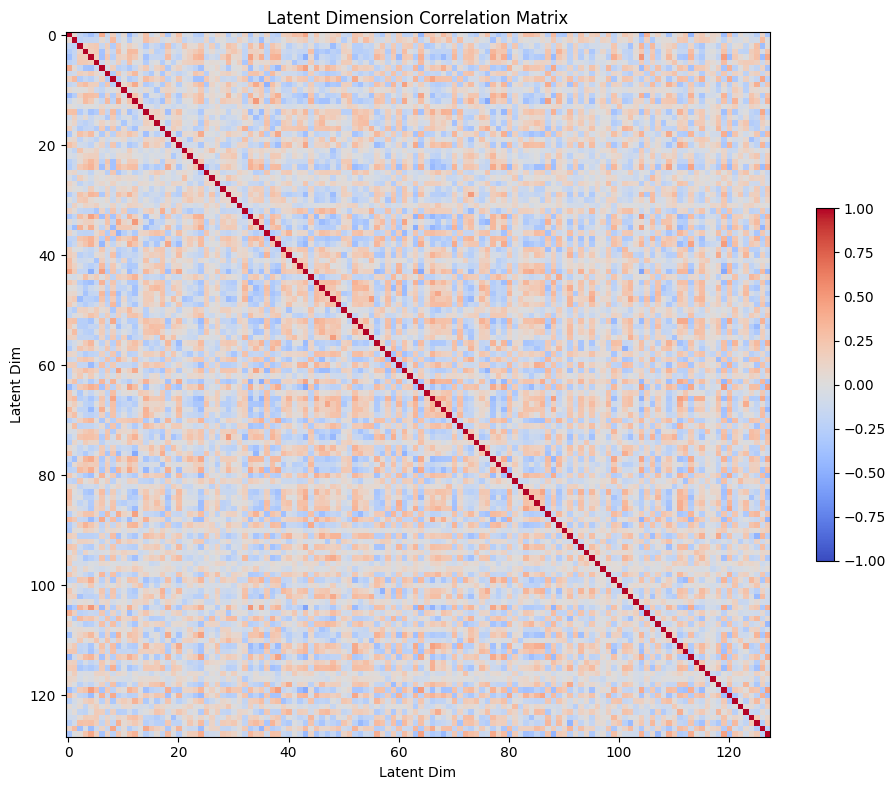


Top 128 most correlated latent dimension pairs:
z[043] ↔ z[104]: corr = -0.5665
z[043] ↔ z[064]: corr = -0.5310
z[043] ↔ z[119]: corr = -0.5289
z[012] ↔ z[076]: corr = -0.5258
z[033] ↔ z[104]: corr = 0.5174
z[004] ↔ z[104]: corr = 0.5096
z[035] ↔ z[063]: corr = -0.5000
z[012] ↔ z[034]: corr = 0.4946
z[004] ↔ z[043]: corr = -0.4896
z[029] ↔ z[073]: corr = 0.4860
z[064] ↔ z[119]: corr = 0.4859
z[004] ↔ z[119]: corr = 0.4843
z[038] ↔ z[119]: corr = 0.4811
z[063] ↔ z[066]: corr = 0.4800
z[048] ↔ z[055]: corr = 0.4798
z[066] ↔ z[104]: corr = -0.4759
z[057] ↔ z[101]: corr = -0.4704
z[009] ↔ z[036]: corr = -0.4699
z[061] ↔ z[076]: corr = -0.4674
z[006] ↔ z[043]: corr = 0.4670
z[064] ↔ z[104]: corr = 0.4642
z[066] ↔ z[088]: corr = 0.4632
z[091] ↔ z[125]: corr = -0.4631
z[035] ↔ z[066]: corr = -0.4609
z[088] ↔ z[127]: corr = -0.4596
z[033] ↔ z[063]: corr = -0.4593
z[012] ↔ z[087]: corr = 0.4588
z[024] ↔ z[109]: corr = 0.4587
z[088] ↔ z[104]: corr = -0.4582
z[035] ↔ z[126]: corr = -0.4581
z[009

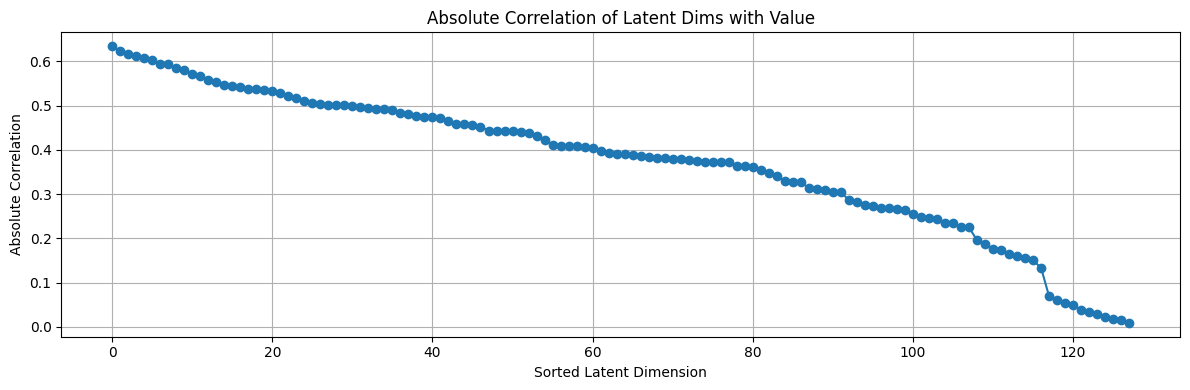

In [9]:
import numpy as np
import torch

import numpy as np
import torch

# Where correlation matrix is on the full z, and the `corr_value` is derived specifically from the input value dimension
# IMPORTANT: This should only be used with this "stage 1" model
def analyze_latent_correlation_matrix_streaming(model, val_loader, device):
    model.eval()
    model.to(device)

    latent_dim = model.hparams.latent_dim

    count = 0
    mean_z = np.zeros(latent_dim)
    m2_z = np.zeros(latent_dim)
    cov_z = np.zeros((latent_dim, latent_dim))

    # For value correlation
    mean_val = 0.0
    m2_val = 0.0
    cov_val = np.zeros(latent_dim)

    for batch in val_loader:
        x, y, _ = batch
        x = x.to(device)
        y = y.to(device)

        z = model.encode(x).detach().cpu().numpy()  # [B, D]
        v = y[:, -1].detach().cpu().numpy()         # [B]

        for zi, vi in zip(z, v):
            count += 1

            # === Update latent stats (Welford) ===
            delta_z = zi - mean_z
            mean_z += delta_z / count
            m2_z += delta_z * (zi - mean_z)

            # === Update cov_z (outer product) ===
            cov_z += np.outer(delta_z, zi - mean_z)

            # === Update value stats ===
            delta_v = vi - mean_val
            mean_val += delta_v / count
            m2_val += delta_v * (vi - mean_val)

            # === Update cov_val ===
            cov_val += delta_z * (vi - mean_val)

        # break

    var_z = m2_z / (count - 1)
    var_val = m2_val / (count - 1)
    cov_z /= (count - 1)
    cov_val /= (count - 1)

    std_z = np.sqrt(var_z + 1e-8)
    std_val = np.sqrt(var_val + 1e-8)

    corr_matrix = cov_z / (std_z[:, None] * std_z[None, :])
    corr_value = cov_val / (std_z * std_val)

    return corr_matrix, corr_value


print("\n=== Computing latent correlation matrix... ===")
corr_matrix, corr_value = analyze_latent_correlation_matrix_streaming(model, val_loader, device=device)

import matplotlib.pyplot as plt

def plot_correlation_matrix(corr_matrix, title="Latent Dimension Correlation Matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar(shrink=0.5)
    plt.title(title)
    plt.xlabel("Latent Dim")
    plt.ylabel("Latent Dim")
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(corr_matrix)

top_k = 128

def print_top_latent_correlations(corr_matrix, top_k=top_k):
    dim = corr_matrix.shape[0]
    pairs = []

    for i in range(dim):
        for j in range(i + 1, dim):
            corr = corr_matrix[i, j]
            pairs.append(((i, j), corr))

    top_corrs = sorted(pairs, key=lambda x: -abs(x[1]))[:top_k]

    print(f"\nTop {top_k} most correlated latent dimension pairs:")
    for (i, j), corr in top_corrs:
        print(f"z[{i:03d}] ↔ z[{j:03d}]: corr = {corr:.4f}")


print_top_latent_correlations(corr_matrix, top_k=top_k)


top_dims = sorted(enumerate(corr_value), key=lambda x: -abs(x[1]))[:top_k]
print("\nTop latent dimensions most correlated with scaled value:")
for i, c in top_dims:
    print(f"z[{i:03d}]: corr = {c:.4f}")


plt.figure(figsize=(12, 4))
plt.plot(np.sort(np.abs(corr_value))[::-1], marker='o')
plt.title("Absolute Correlation of Latent Dims with Value")
plt.xlabel("Sorted Latent Dimension")
plt.ylabel("Absolute Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

